<a href="https://colab.research.google.com/github/Parsagh05/Self-Supervised-SimCLR-PyTorch/blob/main/Self_Supervised_SimCLR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
name = "Parsa Gholami"
student_number = "401100477"

# Introduction

In recent years, self-supervised learning and contrastive learning have gained significant attention as powerful techniques for learning useful data representations without the need for explicit labels. These approaches are particularly valuable in fields like natural language processing (NLP), computer vision, and recommendation systems, where obtaining labeled data can be time-consuming and expensive.

Self-supervised learning leverages unlabeled data to create pretext tasks, allowing models to learn robust feature representations that can be used for various downstream tasks such as classification, detection, and similarity search. Contrastive learning, a key method within the self-supervised learning framework, focuses on learning by comparing positive pairs (similar data points) and negative pairs (dissimilar data points) to maximize the similarity of the positive pairs while minimizing that of the negative pairs.

In this notebook, we will explore the principles of self-supervised and contrastive learning, focusing on how these techniques can be applied to image datasets like CIFAR-10. Through hands-on experiments, we will train models using contrastive learning methods and analyze their performance, exploring the potential benefits of these approaches in real-world scenarios.

# Import Libraries

In [2]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, Subset
import random
from PIL import Image, ImageOps
import numpy as np
import os
import random
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torchvision.transforms import RandAugment

import torchvision.transforms.functional as F # better be as TF but ...

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"\nUsing device: {device}")


Using device: cuda


# Baseline

## Dataset

In real-world training scenarios, it's common to have access to only a subset label of the full dataset. For this example, we will use a subset of the CIFAR-10 dataset, specifically 5000 samples, and train a basic model to evaluate its accuracy and loss. Complete #TODO parts.

In [4]:
transform = transforms.Compose([
    RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])
batch_size = 64

train_dataset = datasets.CIFAR10(download=True, root='./data', train=True, transform=transform)
train_dataset = Subset(train_dataset, list(range(5000)))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = datasets.CIFAR10(download=True, root='./data', train=False, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 170M/170M [00:14<00:00, 11.9MB/s]


## Model

Next, create a simple network to train on the CIFAR-10 subset and report its loss and accuracy.

In [5]:
class Network(nn.Module):
    """
      A simple convolutional neural network designed for image classification on the CIFAR-10 dataset.

      The network should consists of:
      - A `self.backbone` containing convolutional layers, ReLU activations, and batch normalization,
      - A `self.fc` layer that flattens the feature map and reduces its dimensions,
      - A `self.classification_head` that outputs predictions for a given number of classes (default is 10, suitable for CIFAR-10).

      Args:
          num_classes (int): The number of output classes for classification. Defaults to 10 for CIFAR-10.

      Methods:
          forward(x):
              Defines the forward pass through the network.
    """
    def __init__(self, num_classes=10):
        super(Network, self).__init__()
        self.backbone = nn.Sequential(
            # Block 1: Input 3x32x32 -> Output 32x16x16
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2: Input 32x16x16 -> Output 64x8x8
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3: Input 64x8x8 -> Output 128x4x4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
        )

        self.classification_head = nn.Linear(512, num_classes)

    def forward(self, x):
        # =================== TODO ======================

        # 1. Pass input through the backbone
        x = self.backbone(x)

        # 2. Flatten the output of the backbone to prepare for the fully connected layers.
        # x.size(0) is the batch size. -1 infers the remaining dimensions.
        x = x.view(x.size(0), -1)

        # 3. Pass through the fully connected layer
        x = self.fc(x)

        # 4. Pass through the final classification head to get logits
        x = self.classification_head(x)

        return x

        # ===============================================

### create model

In [6]:
model = Network().to(device)

### model info

In [7]:
# --- Model Summary using torchinfo ---
try:
    from torchinfo import summary
except ImportError:
    print("torchinfo not found. Installing...")
    import subprocess
    import sys
    subprocess.check_call([sys.executable, "-m", "pip", "install", "torchinfo"])
    from torchinfo import summary

print("\n--- Model Summary ---")
summary(model,
        input_size=(batch_size, 3, 32, 32),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"],
        depth=4 # Show more detail in the nested modules
)

torchinfo not found. Installing...

--- Model Summary ---


Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
Network (Network)                        [64, 3, 32, 32]      [64, 10]             --                   True
├─Sequential (backbone)                  [64, 3, 32, 32]      [64, 128, 4, 4]      --                   True
│    └─Conv2d (0)                        [64, 3, 32, 32]      [64, 32, 32, 32]     896                  True
│    └─ReLU (1)                          [64, 32, 32, 32]     [64, 32, 32, 32]     --                   --
│    └─MaxPool2d (2)                     [64, 32, 32, 32]     [64, 32, 16, 16]     --                   --
│    └─Conv2d (3)                        [64, 32, 16, 16]     [64, 64, 16, 16]     18,496               True
│    └─ReLU (4)                          [64, 64, 16, 16]     [64, 64, 16, 16]     --                   --
│    └─MaxPool2d (5)                     [64, 64, 16, 16]     [64, 64, 8, 8]       --                   --
│    └─Conv2d (6)     

## Train and Test

In [8]:
# Hyperparameters
num_epochs = 20 # Number of times to iterate over the entire dataset
learning_rate = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Dictionary to store metrics for plotting later
history = {
    'train_loss': [],
    'train_acc': [],
    'test_loss': [],
    'test_acc': []
}

In [9]:
for epoch in range(num_epochs):
    # --- Training Phase ---
    model.train()  # Set the model to training mode

    running_train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Use tqdm for a progress bar over the training data
    train_progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Training]")

    for images, labels in train_progress_bar:
        # Move data to the device
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update training metrics
        running_train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # --- Evaluation Phase ---
    model.eval()  # Set the model to evaluation mode

    running_test_loss = 0.0
    correct_test = 0
    total_test = 0

    # Disable gradient calculation for efficiency
    with torch.no_grad():
        test_progress_bar = tqdm(test_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Testing]")
        for images, labels in test_progress_bar:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Update testing metrics
            running_test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    # Calculate average loss and accuracy for the epoch
    epoch_train_loss = running_train_loss / len(train_loader.dataset)
    epoch_train_acc = 100 * correct_train / total_train

    epoch_test_loss = running_test_loss / len(test_loader.dataset)
    epoch_test_acc = 100 * correct_test / total_test

    # Store metrics in history
    history['train_loss'].append(epoch_train_loss)
    history['train_acc'].append(epoch_train_acc)
    history['test_loss'].append(epoch_test_loss)
    history['test_acc'].append(epoch_test_acc)

    # Print summary for the epoch
    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {epoch_train_loss:.4f} | Train Acc: {epoch_train_acc:.2f}% | "
          f"Test Loss: {epoch_test_loss:.4f} | Test Acc: {epoch_test_acc:.2f}%")

Epoch 1/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 1/20 | Train Loss: 2.0782 | Train Acc: 23.86% | Test Loss: 1.8661 | Test Acc: 32.01%


Epoch 2/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 2/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 2/20 | Train Loss: 1.7609 | Train Acc: 36.88% | Test Loss: 1.7118 | Test Acc: 38.36%


Epoch 3/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 3/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 3/20 | Train Loss: 1.6100 | Train Acc: 41.46% | Test Loss: 1.5656 | Test Acc: 43.25%


Epoch 4/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 4/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 4/20 | Train Loss: 1.5222 | Train Acc: 44.88% | Test Loss: 1.6236 | Test Acc: 41.93%


Epoch 5/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 5/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 5/20 | Train Loss: 1.4424 | Train Acc: 48.76% | Test Loss: 1.5162 | Test Acc: 45.55%


Epoch 6/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 6/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 6/20 | Train Loss: 1.3531 | Train Acc: 52.62% | Test Loss: 1.4873 | Test Acc: 47.46%


Epoch 7/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 7/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 7/20 | Train Loss: 1.2468 | Train Acc: 55.28% | Test Loss: 1.3684 | Test Acc: 51.83%


Epoch 8/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 8/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 8/20 | Train Loss: 1.1941 | Train Acc: 57.42% | Test Loss: 1.3933 | Test Acc: 51.44%


Epoch 9/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 9/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 9/20 | Train Loss: 1.1194 | Train Acc: 60.04% | Test Loss: 1.4071 | Test Acc: 52.57%


Epoch 10/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 10/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 10/20 | Train Loss: 1.0804 | Train Acc: 62.22% | Test Loss: 1.3870 | Test Acc: 51.98%


Epoch 11/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 11/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 11/20 | Train Loss: 1.0251 | Train Acc: 64.18% | Test Loss: 1.2549 | Test Acc: 55.87%


Epoch 12/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 12/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 12/20 | Train Loss: 0.9616 | Train Acc: 66.14% | Test Loss: 1.2937 | Test Acc: 56.14%


Epoch 13/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 13/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 13/20 | Train Loss: 0.8818 | Train Acc: 68.62% | Test Loss: 1.2523 | Test Acc: 56.73%


Epoch 14/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 14/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 14/20 | Train Loss: 0.8745 | Train Acc: 69.34% | Test Loss: 1.3310 | Test Acc: 54.54%


Epoch 15/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 15/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 15/20 | Train Loss: 0.8084 | Train Acc: 72.50% | Test Loss: 1.2427 | Test Acc: 57.37%


Epoch 16/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 16/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 16/20 | Train Loss: 0.7805 | Train Acc: 72.06% | Test Loss: 1.3395 | Test Acc: 56.27%


Epoch 17/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 17/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 17/20 | Train Loss: 0.7465 | Train Acc: 74.90% | Test Loss: 1.2302 | Test Acc: 58.86%


Epoch 18/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 18/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 18/20 | Train Loss: 0.6759 | Train Acc: 76.26% | Test Loss: 1.2773 | Test Acc: 58.58%


Epoch 19/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 19/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 19/20 | Train Loss: 0.6928 | Train Acc: 76.44% | Test Loss: 1.3630 | Test Acc: 56.33%


Epoch 20/20 [Training]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 20/20 [Testing]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch 20/20 | Train Loss: 0.6209 | Train Acc: 78.64% | Test Loss: 1.3351 | Test Acc: 59.53%


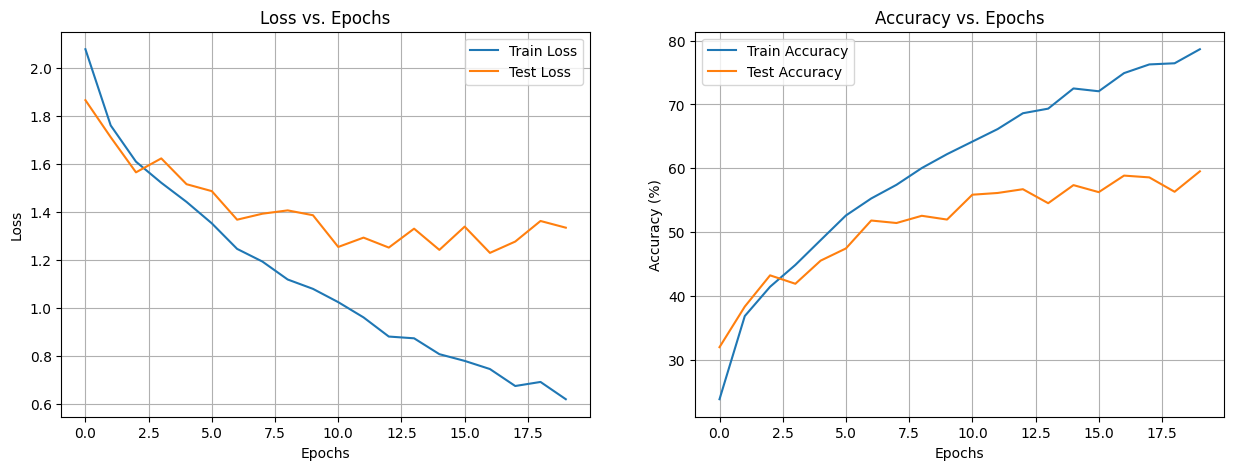

In [10]:
# --- Plotting the Results ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot training and testing loss
ax1.plot(history['train_loss'], label='Train Loss')
ax1.plot(history['test_loss'], label='Test Loss')
ax1.set_title('Loss vs. Epochs')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# Plot training and testing accuracy
ax2.plot(history['train_acc'], label='Train Accuracy')
ax2.plot(history['test_acc'], label='Test Accuracy')
ax2.set_title('Accuracy vs. Epochs')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy (%)')
ax2.legend()
ax2.grid(True)

plt.show()

# Self Supervised Learning

Now, we want to apply self-supervised methods by first training the model on augmented data, and then training the model on the real labeled data to observe the effects of this approach.

To create the augmented data, define a CIFAR10PretextDataset class that applies random transformations to the images. These transformations should include:

Rotating the image by one of the following angles: 0°, 90°, 180°, or 270°.

Shearing the image by one of the following factors: 0.0, 0.2, or 0.4.

Changing the color mode of the image to one of the following: 'original', 'grayscale', or 'color_inverted'.

After that, create a network that predicts these transformations as well as the image labels. Train the model using the first 1000 samples from the CIFAR-10 dataset. Ensure that the network has the same backbone as the baseline model to make a fair comparison.

**NOTE** : Here you said train the model using the first 1000 samples but in your output you trained with all samples!

In [11]:
from PIL import Image, ImageOps # Image.AFFINE is part of the PIL.Image module

class CIFAR10PretextDataset(Dataset):
    """
    A custom dataset class for applying self-supervised learning pretext tasks on the CIFAR-10 dataset.

    This class augments the CIFAR-10 images with random transformations to create pretext tasks for self-supervised learning.
    The transformations applied include:
    - Random rotations (0°, 90°, 180°, 270°),
    - Random shearing (0.0, 0.2, 0.4),
    - Random color mode changes (original, grayscale, color inverted).

    The goal of these transformations is to create a task where the model must predict the type of transformation applied to the image, which can then be used as a self-supervised learning task.

    Args:
        root (str): Directory where the CIFAR-10 dataset will be stored or loaded from.
        train (bool): Whether to load the training dataset (True) or test dataset (False).
        transform (callable, optional): A function/transform to apply to the image (default is None).

    Attributes:
        dataset (torchvision.datasets.CIFAR10): The CIFAR-10 dataset.
        rotation_angles (list): List of angles (0°, 90°, 180°, 270°) for random rotations.
        shear_factors (list): List of shear factors (0.0, 0.2, 0.4) for random shearing.
        color_modes (list): List of color modes ('original', 'grayscale', 'color_inverted') for random color transformations.

    Methods:
        __len__(): Returns the total number of samples in the dataset.
        __getitem__(idx): Returns an augmented image and its corresponding label (rotational, shear, and color transformation indices).
    """

    def __init__(self, root, train=True, transform=None):
        self.dataset = torchvision.datasets.CIFAR10(root=root, train=train, download=True)
        self.transform = transform

        self.rotation_angles = [0, 90, 180, 270]
        self.shear_factors = [0.0, 0.2, 0.4]
        self.color_modes = ['original', 'grayscale', 'color_inverted']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, _ = self.dataset[idx]

        # --- Select random transformations ---
        rotation_label = random.randint(0, len(self.rotation_angles) - 1)
        shear_label = random.randint(0, len(self.shear_factors) - 1)
        color_label = random.randint(0, len(self.color_modes) - 1)

        angle = self.rotation_angles[rotation_label]
        shear = self.shear_factors[shear_label]
        color_mode = self.color_modes[color_label]

        # --- Apply transformations ---
        transformed_image = image

        # A. Geometric Transformations
        # 1. Rotate first
        transformed_image = F.rotate(transformed_image, angle)

        # 2. Shear second (using the new method)
        # ======================= NEW SHEARING METHOD =======================
        # Create the affine matrix tuple for shearing
        shear_matrix_tuple = (1, shear, 0, 0, 1, 0)
        # Apply the transformation using PIL's transform method
        transformed_image = transformed_image.transform(
            transformed_image.size,
            Image.AFFINE,
            shear_matrix_tuple,
            resample=Image.BICUBIC # Use a high-quality resampling filter
        )
        # =================================================================

        # B. Color Transformation
        if color_mode == 'grayscale':
            transformed_image = F.rgb_to_grayscale(transformed_image, num_output_channels=3)
        elif color_mode == 'color_inverted':
            transformed_image = ImageOps.invert(transformed_image.convert('RGB'))

        # C. Final standard transforms
        if self.transform:
            transformed_image = self.transform(transformed_image)

        pretext_labels = (
            torch.tensor(rotation_label, dtype=torch.long),
            torch.tensor(shear_label, dtype=torch.long),
            torch.tensor(color_label, dtype=torch.long)
        )
        return transformed_image, pretext_labels
        # ================================================

--- Displaying 5 Original vs. Transformed Images ---


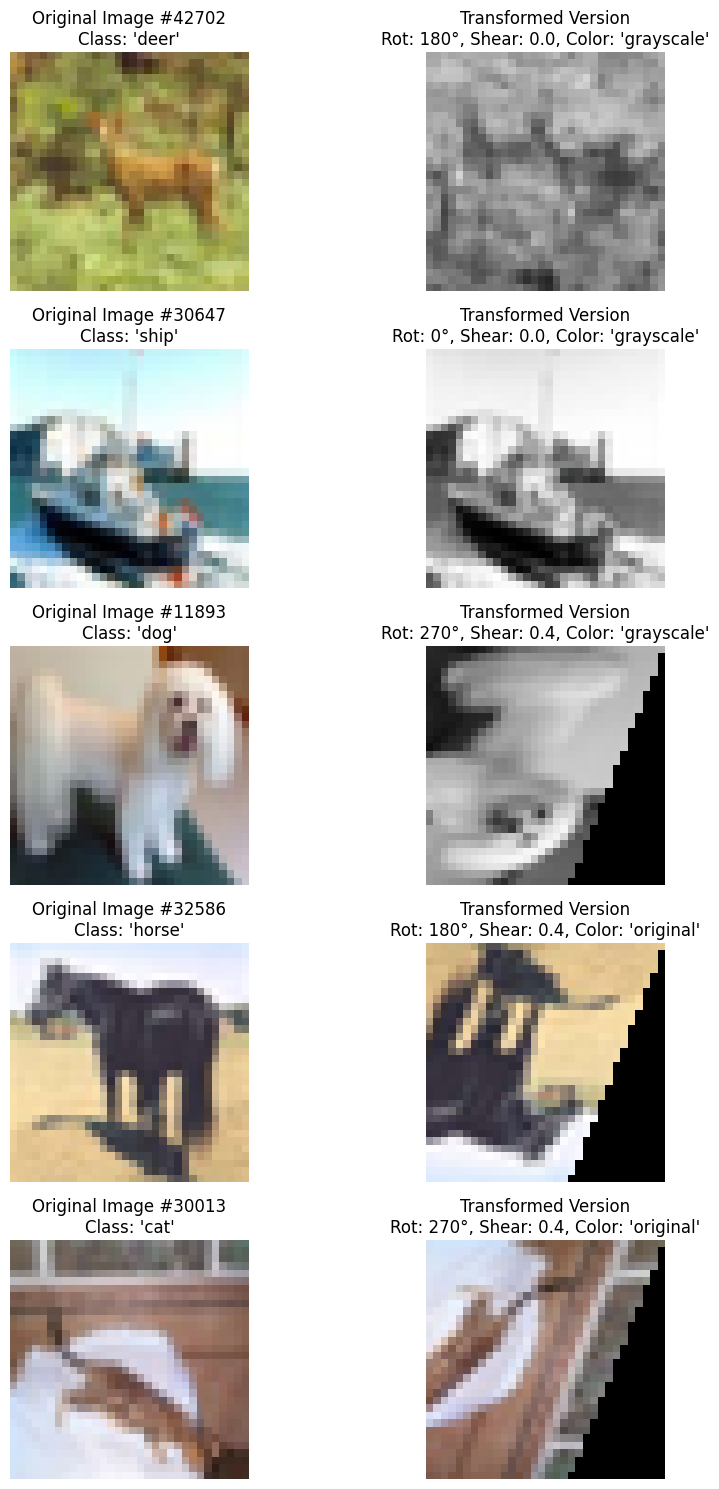

In [12]:
# 2. The Visualization Function
def visualize_pretext_transformations(num_images=5):
    """
    Plots a comparison of original CIFAR-10 images and their
    randomly transformed versions from the Pretext Dataset.
    """
    original_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True)
    class_names = original_dataset.classes

    pretext_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
    ])
    pretext_dataset = CIFAR10PretextDataset(root='./data', train=True, transform=pretext_transform)

    cifar_mean = [0.4914, 0.4822, 0.4465]
    cifar_std = [0.247, 0.243, 0.261]

    def unnormalize(tensor, mean, std):
        tensor = tensor.clone()
        for t, m, s in zip(tensor, mean, std):
            t.mul_(s).add_(m)
        return tensor

    print(f"--- Displaying {num_images} Original vs. Transformed Images ---")
    fig, axes = plt.subplots(num_images, 2, figsize=(10, 3 * num_images))
    if num_images == 1:
        axes = np.array([axes])

    for i in range(num_images):
        idx = random.randint(0, len(original_dataset) - 1)
        original_image, original_label_idx = original_dataset[idx]
        original_label_name = class_names[original_label_idx]
        transformed_tensor, (rot_label, shear_label, color_label) = pretext_dataset[idx]

        rot_val = pretext_dataset.rotation_angles[rot_label]
        shear_val = pretext_dataset.shear_factors[shear_label]
        color_val = pretext_dataset.color_modes[color_label]

        axes[i, 0].imshow(original_image)
        axes[i, 0].set_title(f"Original Image #{idx}\nClass: '{original_label_name}'")
        axes[i, 0].axis('off')

        unnormalized_tensor = unnormalize(transformed_tensor, cifar_mean, cifar_std)
        image_np = unnormalized_tensor.numpy().transpose(1, 2, 0)
        axes[i, 1].imshow(np.clip(image_np, 0, 1))
        axes[i, 1].set_title(f"Transformed Version\nRot: {rot_val}°, Shear: {shear_val}, Color: '{color_val}'")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# 3. Run the visualization immediately
visualize_pretext_transformations(num_images=5)

In [13]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])
batch_size = 64

# train_dataset = CIFAR10PretextDataset(root='./data', train=True, transform=transform)
# train_subset = Subset(train_dataset, list(range(1000)))
# self_supervised_train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)

train_dataset = CIFAR10PretextDataset(root='./data', train=True, transform=transform)
self_supervised_train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CIFAR10PretextDataset(root='./data', train=False, transform=transform)
self_supervised_test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Now implement the model.

In [14]:
class Supervised_Learning(nn.Module):
    def __init__(self, num_classes = 10):
        """
        Initialize the Supervised_Learning model.
        Note that the backbone shoule be the same as the baseline model.
        Init seperate head for rotation, shear, color and classification.
        Args:
            num_classes (int): Number of output classes for classification.
        """
        # =========================== TODO ===========================
        super(Supervised_Learning, self).__init__()
        self.backbone = nn.Sequential(
            # Block 1: Input 3x32x32 -> Output 32x16x16
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 2: Input 32x16x16 -> Output 64x8x8
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Block 3: Input 64x8x8 -> Output 128x4x4
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
        )

        self.rotation_head = nn.Linear(512, 4)  # 4 rotation classes (0, 90, 180, 270)
        self.shear_head = nn.Linear(512, 3)     # 3 shear classes (0.0, 0.2, 0.4)
        self.color_head = nn.Linear(512, 3)     # 3 color classes (original, grayscale, inverted)
        self.classification_head = nn.Linear(512, num_classes) # For the final downstream task


        # ============================================================

    def extract_features(self, x):
        x = self.backbone(x)
        return x

    def forward(self, x):
        # =========================== TODO ===========================
        # 1. Extract features using the backbone.
        features = self.backbone(x)

        # 2. Flatten the features to a vector.
        features = features.view(features.size(0), -1)

        # 3. Pass features through the shared fully connected layer.
        shared_features = self.fc(features)

        # 4. Get predictions from each separate head.
        rotation_preds = self.rotation_head(shared_features)
        shear_preds = self.shear_head(shared_features)
        color_preds = self.color_head(shared_features)
        class_preds = self.classification_head(shared_features)

        # Return the predictions for all tasks. The training loop will decide which ones to use.
        return rotation_preds, shear_preds, color_preds, class_preds
        # ============================================================


In [15]:
pretext_model = Supervised_Learning().to(device)

learning_rate = 0.001
num_epochs_pretext = 20
optimizer = torch.optim.Adam(pretext_model.parameters(), lr=learning_rate)
criterion = nn.CrossEntropyLoss()

# Dictionary to store metrics for plotting
history = {
    'train_loss': [], 'test_loss': [],
    'train_acc_rot': [], 'train_acc_shear': [], 'train_acc_color': [],
    'test_acc_rot': [], 'test_acc_shear': [], 'test_acc_color': []
}

In [16]:
# 2. Training and Evaluation Loop for Pretext Tasks
print("--- Starting Self-Supervised Pre-training ---")
for epoch in range(num_epochs_pretext):
    # --- Training Phase ---
    pretext_model.train()
    running_train_loss = 0.0
    correct_rot_train, total_rot_train = 0, 0
    correct_shear_train, total_shear_train = 0, 0
    correct_color_train, total_color_train = 0, 0

    for images, (rot_labels, shear_labels, color_labels) in tqdm(self_supervised_train_loader, desc=f"Epoch {epoch+1} [Train]"):
        images = images.to(device)
        rot_labels, shear_labels, color_labels = rot_labels.to(device), shear_labels.to(device), color_labels.to(device)

        optimizer.zero_grad()
        rot_preds, shear_preds, color_preds, _ = pretext_model(images)

        loss_rot = criterion(rot_preds, rot_labels)
        loss_shear = criterion(shear_preds, shear_labels)
        loss_color = criterion(color_preds, color_labels)
        total_loss = loss_rot + loss_shear + loss_color

        total_loss.backward()
        optimizer.step()

        running_train_loss += total_loss.item() * images.size(0)

        # Accuracy for rotation
        _, predicted_rot = torch.max(rot_preds.data, 1)
        total_rot_train += rot_labels.size(0)
        correct_rot_train += (predicted_rot == rot_labels).sum().item()

        # Accuracy for shear
        _, predicted_shear = torch.max(shear_preds.data, 1)
        total_shear_train += shear_labels.size(0)
        correct_shear_train += (predicted_shear == shear_labels).sum().item()

        # Accuracy for color
        _, predicted_color = torch.max(color_preds.data, 1)
        total_color_train += color_labels.size(0)
        correct_color_train += (predicted_color == color_labels).sum().item()

    # --- Evaluation Phase ---
    pretext_model.eval()
    running_test_loss = 0.0
    correct_rot_test, total_rot_test = 0, 0
    correct_shear_test, total_shear_test = 0, 0
    correct_color_test, total_color_test = 0, 0

    with torch.no_grad():
        for images, (rot_labels, shear_labels, color_labels) in tqdm(self_supervised_test_loader, desc=f"Epoch {epoch+1} [Test]"):
            images = images.to(device)
            rot_labels, shear_labels, color_labels = rot_labels.to(device), shear_labels.to(device), color_labels.to(device)

            rot_preds, shear_preds, color_preds, _ = pretext_model(images)
            loss_rot = criterion(rot_preds, rot_labels)
            loss_shear = criterion(shear_preds, shear_labels)
            loss_color = criterion(color_preds, color_labels)
            total_loss = loss_rot + loss_shear + loss_color
            running_test_loss += total_loss.item() * images.size(0)

            _, predicted_rot = torch.max(rot_preds.data, 1)
            total_rot_test += rot_labels.size(0)
            correct_rot_test += (predicted_rot == rot_labels).sum().item()

            _, predicted_shear = torch.max(shear_preds.data, 1)
            total_shear_test += shear_labels.size(0)
            correct_shear_test += (predicted_shear == shear_labels).sum().item()

            _, predicted_color = torch.max(color_preds.data, 1)
            total_color_test += color_labels.size(0)
            correct_color_test += (predicted_color == color_labels).sum().item()

    # --- Calculate and Store Metrics ---
    # Loss
    epoch_train_loss = running_train_loss / len(self_supervised_train_loader.dataset)
    epoch_test_loss = running_test_loss / len(self_supervised_test_loader.dataset)
    history['train_loss'].append(epoch_train_loss)
    history['test_loss'].append(epoch_test_loss)
    # Train Accuracies
    acc_rot_train = 100 * correct_rot_train / total_rot_train
    acc_shear_train = 100 * correct_shear_train / total_shear_train
    acc_color_train = 100 * correct_color_train / total_color_train
    history['train_acc_rot'].append(acc_rot_train)
    history['train_acc_shear'].append(acc_shear_train)
    history['train_acc_color'].append(acc_color_train)
    # Test Accuracies
    acc_rot_test = 100 * correct_rot_test / total_rot_test
    acc_shear_test = 100 * correct_shear_test / total_shear_test
    acc_color_test = 100 * correct_color_test / total_color_test
    history['test_acc_rot'].append(acc_rot_test)
    history['test_acc_shear'].append(acc_shear_test)
    history['test_acc_color'].append(acc_color_test)

    # --- Print Epoch Results in the specified format ---
    print(f"Epoch [{epoch+1}/{num_epochs_pretext}] - Train Loss: {epoch_train_loss:.4f}, Test Loss: {epoch_test_loss:.4f}")
    print(f"Train Accuracy - Rotation: {acc_rot_train:.2f}%, Shear: {acc_shear_train:.2f}%, Color: {acc_color_train:.2f}%")
    print(f"Test Accuracy - Rotation: {acc_rot_test:.2f}%, Shear: {acc_shear_test:.2f}%, Color: {acc_color_test:.2f}%\n")

print("--- Pre-training Finished ---")

--- Starting Self-Supervised Pre-training ---


Epoch 1 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 1 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [1/20] - Train Loss: 1.5128, Test Loss: 1.3062
Train Accuracy - Rotation: 45.16%, Shear: 97.87%, Color: 89.45%
Test Accuracy - Rotation: 50.72%, Shear: 99.16%, Color: 94.26%



Epoch 2 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 2 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [2/20] - Train Loss: 1.2209, Test Loss: 1.1589
Train Accuracy - Rotation: 54.63%, Shear: 99.26%, Color: 94.56%
Test Accuracy - Rotation: 56.76%, Shear: 99.63%, Color: 95.10%



Epoch 3 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 3 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [3/20] - Train Loss: 1.1522, Test Loss: 1.1217
Train Accuracy - Rotation: 57.11%, Shear: 99.46%, Color: 95.27%
Test Accuracy - Rotation: 57.88%, Shear: 99.72%, Color: 95.52%



Epoch 4 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 4 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [4/20] - Train Loss: 1.1020, Test Loss: 1.0901
Train Accuracy - Rotation: 59.05%, Shear: 99.54%, Color: 95.58%
Test Accuracy - Rotation: 59.64%, Shear: 99.70%, Color: 96.02%



Epoch 5 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 5 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [5/20] - Train Loss: 1.0634, Test Loss: 1.0515
Train Accuracy - Rotation: 60.61%, Shear: 99.57%, Color: 96.03%
Test Accuracy - Rotation: 60.37%, Shear: 99.71%, Color: 96.15%



Epoch 6 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 6 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [6/20] - Train Loss: 1.0260, Test Loss: 1.0107
Train Accuracy - Rotation: 62.50%, Shear: 99.61%, Color: 96.18%
Test Accuracy - Rotation: 62.77%, Shear: 99.65%, Color: 96.24%



Epoch 7 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 7 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [7/20] - Train Loss: 0.9905, Test Loss: 0.9794
Train Accuracy - Rotation: 63.68%, Shear: 99.65%, Color: 96.27%
Test Accuracy - Rotation: 63.80%, Shear: 99.69%, Color: 96.60%



Epoch 8 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 8 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [8/20] - Train Loss: 0.9706, Test Loss: 0.9686
Train Accuracy - Rotation: 64.67%, Shear: 99.64%, Color: 96.35%
Test Accuracy - Rotation: 64.41%, Shear: 99.81%, Color: 96.19%



Epoch 9 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 9 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [9/20] - Train Loss: 0.9439, Test Loss: 0.9383
Train Accuracy - Rotation: 65.62%, Shear: 99.66%, Color: 96.67%
Test Accuracy - Rotation: 65.27%, Shear: 99.76%, Color: 96.71%



Epoch 10 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 10 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [10/20] - Train Loss: 0.9273, Test Loss: 0.9503
Train Accuracy - Rotation: 66.42%, Shear: 99.68%, Color: 96.61%
Test Accuracy - Rotation: 65.29%, Shear: 99.76%, Color: 96.88%



Epoch 11 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 11 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [11/20] - Train Loss: 0.9016, Test Loss: 0.9103
Train Accuracy - Rotation: 67.39%, Shear: 99.70%, Color: 96.89%
Test Accuracy - Rotation: 66.96%, Shear: 99.75%, Color: 97.00%



Epoch 12 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 12 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [12/20] - Train Loss: 0.8948, Test Loss: 0.9037
Train Accuracy - Rotation: 67.78%, Shear: 99.69%, Color: 96.71%
Test Accuracy - Rotation: 67.21%, Shear: 99.75%, Color: 97.22%



Epoch 13 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 13 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [13/20] - Train Loss: 0.8807, Test Loss: 0.8998
Train Accuracy - Rotation: 68.14%, Shear: 99.74%, Color: 96.80%
Test Accuracy - Rotation: 67.29%, Shear: 99.77%, Color: 96.92%



Epoch 14 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 14 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [14/20] - Train Loss: 0.8696, Test Loss: 0.9195
Train Accuracy - Rotation: 68.74%, Shear: 99.72%, Color: 96.78%
Test Accuracy - Rotation: 66.51%, Shear: 99.77%, Color: 96.83%



Epoch 15 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 15 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [15/20] - Train Loss: 0.8517, Test Loss: 0.8729
Train Accuracy - Rotation: 69.39%, Shear: 99.73%, Color: 97.16%
Test Accuracy - Rotation: 68.98%, Shear: 99.80%, Color: 96.56%



Epoch 16 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 16 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [16/20] - Train Loss: 0.8479, Test Loss: 0.8642
Train Accuracy - Rotation: 69.69%, Shear: 99.71%, Color: 97.01%
Test Accuracy - Rotation: 68.70%, Shear: 99.85%, Color: 96.89%



Epoch 17 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 17 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [17/20] - Train Loss: 0.8309, Test Loss: 0.8965
Train Accuracy - Rotation: 70.33%, Shear: 99.72%, Color: 97.09%
Test Accuracy - Rotation: 68.33%, Shear: 99.66%, Color: 96.04%



Epoch 18 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 18 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [18/20] - Train Loss: 0.8425, Test Loss: 0.8642
Train Accuracy - Rotation: 70.44%, Shear: 99.72%, Color: 96.71%
Test Accuracy - Rotation: 68.69%, Shear: 99.78%, Color: 97.17%



Epoch 19 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 19 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [19/20] - Train Loss: 0.8107, Test Loss: 0.8668
Train Accuracy - Rotation: 71.12%, Shear: 99.72%, Color: 97.22%
Test Accuracy - Rotation: 69.34%, Shear: 99.74%, Color: 97.37%



Epoch 20 [Train]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch 20 [Test]:   0%|          | 0/157 [00:00<?, ?it/s]

Epoch [20/20] - Train Loss: 0.8067, Test Loss: 0.8271
Train Accuracy - Rotation: 71.11%, Shear: 99.73%, Color: 97.28%
Test Accuracy - Rotation: 70.33%, Shear: 99.85%, Color: 97.44%

--- Pre-training Finished ---


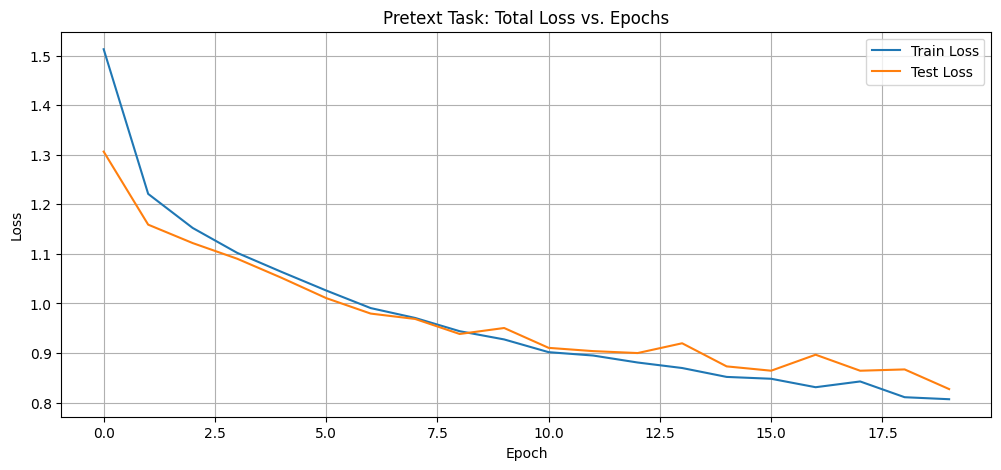

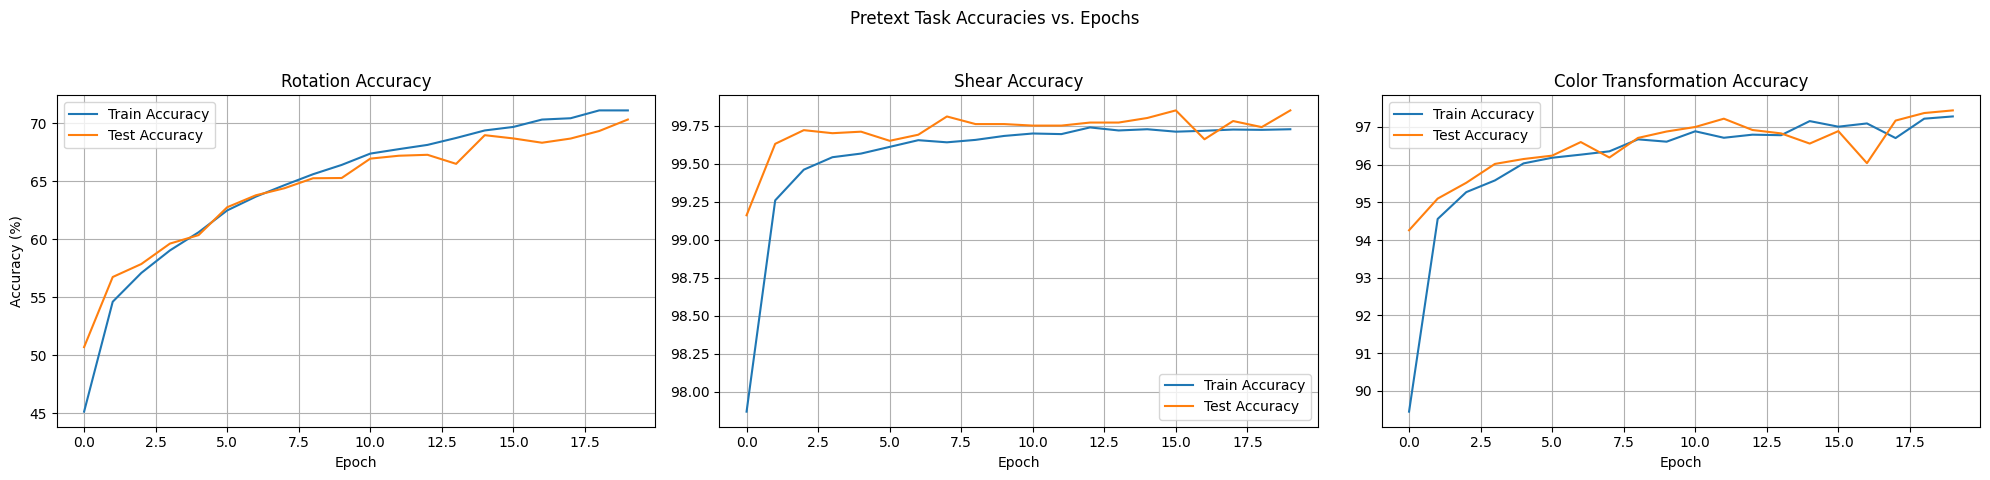

In [17]:
# 3. Plotting Loss and Accuracy Curves
plt.figure(figsize=(12, 5))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['test_loss'], label='Test Loss')
plt.title('Pretext Task: Total Loss vs. Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

fig, axs = plt.subplots(1, 3, figsize=(20, 5))
fig.suptitle('Pretext Task Accuracies vs. Epochs')

# Rotation Accuracy Plot
axs[0].plot(history['train_acc_rot'], label='Train Accuracy')
axs[0].plot(history['test_acc_rot'], label='Test Accuracy')
axs[0].set_title('Rotation Accuracy')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Accuracy (%)')
axs[0].grid(True)
axs[0].legend()

# Shear Accuracy Plot
axs[1].plot(history['train_acc_shear'], label='Train Accuracy')
axs[1].plot(history['test_acc_shear'], label='Test Accuracy')
axs[1].set_title('Shear Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].grid(True)
axs[1].legend()

# Color Accuracy Plot
axs[2].plot(history['train_acc_color'], label='Train Accuracy')
axs[2].plot(history['test_acc_color'], label='Test Accuracy')
axs[2].set_title('Color Transformation Accuracy')
axs[2].set_xlabel('Epoch')
axs[2].grid(True)
axs[2].legend()

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Next, train and evaluate the model using the true labels, and compare its performance with the baseline model.

In [18]:
# --- 1. Define Transform WITHOUT Augmentation ---
# This pipeline only performs the essential steps.
no_aug_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

# --- 2. Setup DataLoaders ---
batch_size = 64
# Load the training data with the non-augmented transform
train_no_aug_dataset = datasets.CIFAR10(download=True, root='./data', train=True, transform=no_aug_transform)
# Use the same 5000 sample subset for a fair comparison
train_no_aug_subset = Subset(train_no_aug_dataset, list(range(5000)))
train_no_aug_loader = DataLoader(train_no_aug_subset, batch_size=batch_size, shuffle=True)

# Test data loader never has augmentations, so it remains the same
test_no_aug_dataset = datasets.CIFAR10(download=True, root='./data', train=False, transform=no_aug_transform)
test_no_aug_loader = DataLoader(test_no_aug_dataset, batch_size=batch_size, shuffle=False)


In [19]:
print("\n--- Starting Supervised Fine-Tuning ---")

# Freeze Pre-trained Layers ---
# We want to stop the backbone and shared FC layer from changing.
# They have already learned good features.
for param in pretext_model.backbone.parameters():
    param.requires_grad = False

for param in pretext_model.fc.parameters():
    param.requires_grad = False

# We *only* want to train the classification head.
# By default, new layers have requires_grad=True, but let's be explicit.
for param in pretext_model.classification_head.parameters():
    param.requires_grad = True


--- Starting Supervised Fine-Tuning ---


In [26]:
model_finetuned = pretext_model
learning_rate = 0.001
num_epochs = 20 # Same as the first baseline
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_finetuned.parameters()),
    lr=learning_rate
)


In [27]:
# --- Training and Evaluation Loop ---
best_test_acc_finetuned = 0.0
for epoch in range(num_epochs):
    model_finetuned.train()
    running_loss = 0.0
    correct_train, total_train = 0, 0

    for images, labels in tqdm(train_no_aug_loader, desc=f"Epoch {epoch+1} [Train]"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        # ===========================
        #  FIX 2: Unpack the model's 4 outputs
        # ===========================
        _, _, _, outputs = model_finetuned(images)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    model_finetuned.eval()
    test_loss = 0.0
    correct_test, total_test = 0, 0
    with torch.no_grad():
        for images, labels in test_no_aug_loader:
            images, labels = images.to(device), labels.to(device)

            # ===========================
            #  FIX 2: Also apply fix in the test loop
            # ===========================
            _, _, _, outputs = model_finetuned(images)

            loss = criterion(outputs, labels)
            test_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_no_aug_loader.dataset)
    train_acc = 100 * correct_train / total_train
    test_loss = test_loss / len(test_no_aug_loader.dataset)
    test_acc = 100 * correct_test / total_test

    if test_acc > best_test_acc_finetuned:
        best_test_acc_finetuned = test_acc

    print(f"Epoch [{epoch+1}/{num_epochs}] | "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% | "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")

print("\n--- Fine-Tuning Finished ---")
print(f"Best Test Accuracy from Fine-Tuning: {best_test_acc_finetuned:.2f}%")

Epoch 1 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [1/20] | Train Loss: 1.4620, Train Acc: 49.10% | Test Loss: 1.4949, Test Acc: 46.96%


Epoch 2 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [2/20] | Train Loss: 1.3920, Train Acc: 50.62% | Test Loss: 1.4662, Test Acc: 47.88%


Epoch 3 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [3/20] | Train Loss: 1.3522, Train Acc: 51.72% | Test Loss: 1.4496, Test Acc: 48.15%


Epoch 4 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [4/20] | Train Loss: 1.3272, Train Acc: 52.40% | Test Loss: 1.4406, Test Acc: 48.26%


Epoch 5 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [5/20] | Train Loss: 1.3066, Train Acc: 53.38% | Test Loss: 1.4359, Test Acc: 48.57%


Epoch 6 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [6/20] | Train Loss: 1.2896, Train Acc: 54.06% | Test Loss: 1.4328, Test Acc: 48.53%


Epoch 7 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [7/20] | Train Loss: 1.2778, Train Acc: 54.52% | Test Loss: 1.4304, Test Acc: 48.46%


Epoch 8 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [8/20] | Train Loss: 1.2666, Train Acc: 54.86% | Test Loss: 1.4312, Test Acc: 48.66%


Epoch 9 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [9/20] | Train Loss: 1.2566, Train Acc: 55.50% | Test Loss: 1.4299, Test Acc: 48.76%


Epoch 10 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [10/20] | Train Loss: 1.2483, Train Acc: 55.66% | Test Loss: 1.4332, Test Acc: 48.65%


Epoch 11 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [11/20] | Train Loss: 1.2404, Train Acc: 55.78% | Test Loss: 1.4324, Test Acc: 48.74%


Epoch 12 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [12/20] | Train Loss: 1.2358, Train Acc: 56.14% | Test Loss: 1.4348, Test Acc: 48.69%


Epoch 13 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [13/20] | Train Loss: 1.2290, Train Acc: 56.50% | Test Loss: 1.4365, Test Acc: 48.43%


Epoch 14 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [14/20] | Train Loss: 1.2236, Train Acc: 56.52% | Test Loss: 1.4388, Test Acc: 48.48%


Epoch 15 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [15/20] | Train Loss: 1.2184, Train Acc: 56.64% | Test Loss: 1.4435, Test Acc: 48.25%


Epoch 16 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [16/20] | Train Loss: 1.2150, Train Acc: 56.44% | Test Loss: 1.4441, Test Acc: 48.42%


Epoch 17 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [17/20] | Train Loss: 1.2133, Train Acc: 56.80% | Test Loss: 1.4467, Test Acc: 48.62%


Epoch 18 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [18/20] | Train Loss: 1.2078, Train Acc: 56.96% | Test Loss: 1.4532, Test Acc: 48.24%


Epoch 19 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [19/20] | Train Loss: 1.2030, Train Acc: 57.58% | Test Loss: 1.4560, Test Acc: 48.09%


Epoch 20 [Train]:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch [20/20] | Train Loss: 1.2018, Train Acc: 57.24% | Test Loss: 1.4554, Test Acc: 48.18%

--- Fine-Tuning Finished ---
Best Test Accuracy from Fine-Tuning: 48.76%


To evaluate the quality of the learned features, complete the function find_top_10_closest_samples. This function should extract features from images using only the self.backbone of the model (not the full classification head), and then compute the top 10 most similar samples for a few randomly chosen test images based on Euclidean distance in the feature space.

Once completed, run the function and analyze the results. The goal is to visually inspect whether the model groups similar images together in its learned feature space, which is especially important for understanding the effectiveness of self-supervised learning.

This qualitative evaluation helps determine whether the backbone is capturing meaningful patterns, even without relying on labels during training.

In [28]:
def unnormalize(tensor, mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261]):
    """Reverses the normalization on a tensor for viewing."""
    tensor = tensor.clone()
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor


Step 1: Extracting features from all training data (gallery)...


  0%|          | 0/79 [00:00<?, ?it/s]


Step 2: Finding top 10 neighbors for 5 random test images...


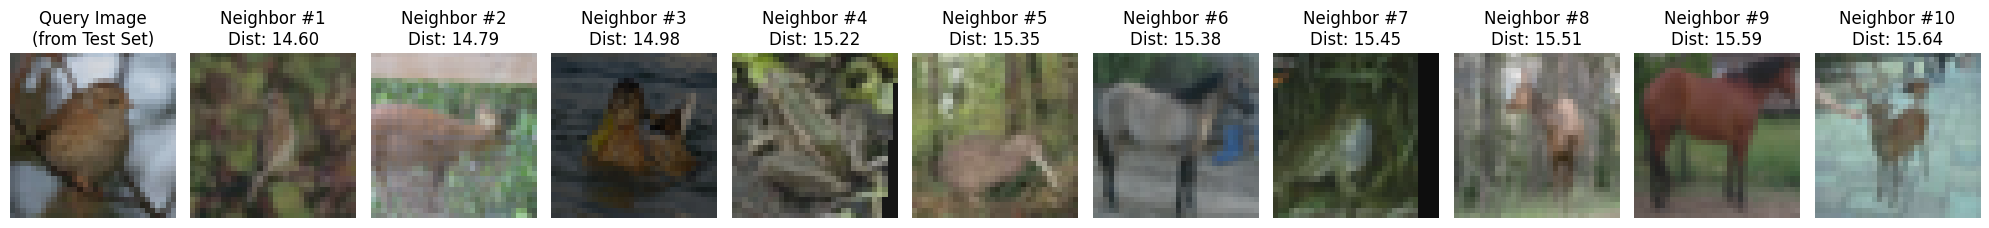

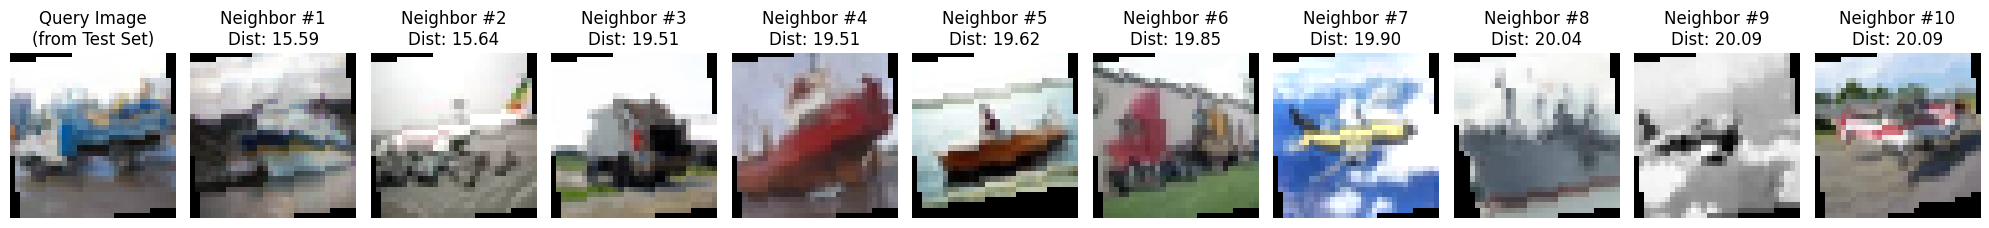

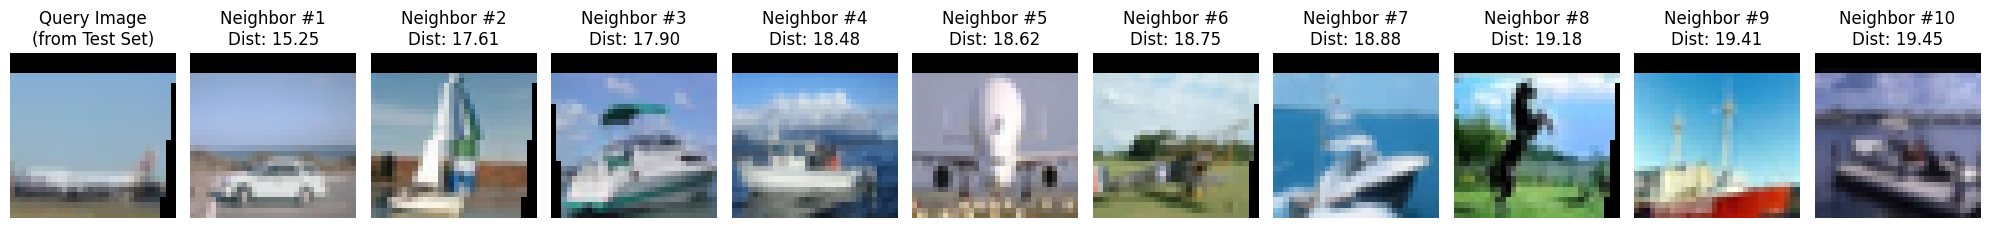

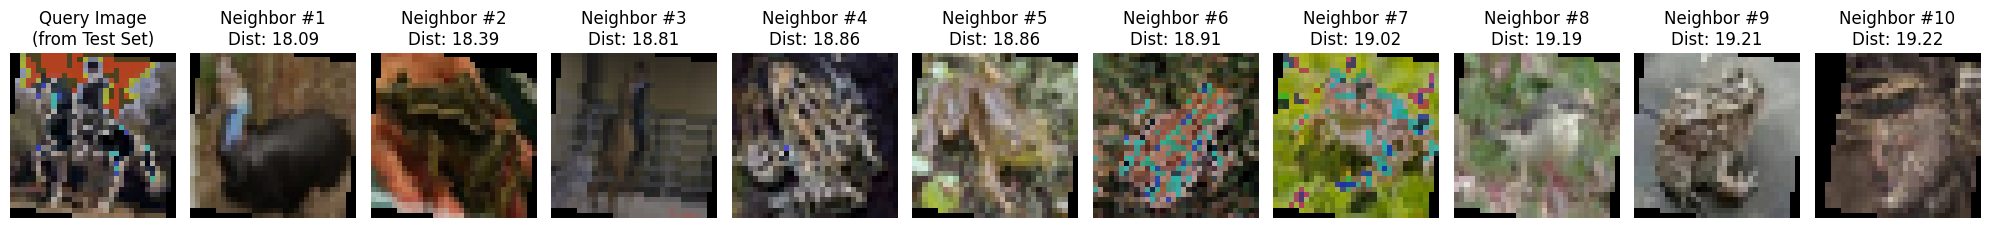

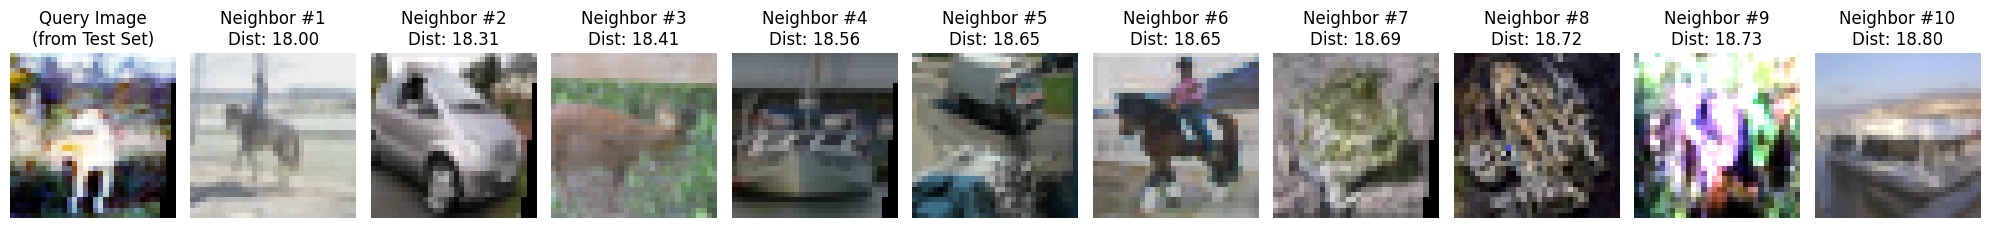

In [29]:
def find_top_k_closest_samples(model, train_loader, test_loader, device, sample_size=5, k=10):
    """
    Finds and plots the top k closest samples from the training set for a few random test samples.

    Args:
        model (nn.Module): The trained model to evaluate.
        train_loader (DataLoader): DataLoader for the training set (gallery).
        test_loader (DataLoader): DataLoader for the test set (queries).
        device (torch.device): The device to run on (e.g., 'cuda' or 'cpu').
        sample_size (int): The number of random test images to find neighbors for.
        k (int): The number of closest neighbors to find.
    """
    # ========================= TODO =========================
    model.eval()
    all_train_features = []
    all_train_images = []

    print("Step 1: Extracting features from all training data (gallery)...")
    with torch.no_grad():
        for images, _ in tqdm(train_loader):
            images = images.to(device)
            # Use only the backbone to extract features
            features = model.backbone(images)
            # Flatten the features and move to CPU for storage
            features = features.view(features.size(0), -1).cpu()
            all_train_features.append(features)
            # Store images (on CPU) for later plotting
            all_train_images.append(images.cpu())

    # Concatenate all features and images into single tensors
    all_train_features = torch.cat(all_train_features, dim=0)
    all_train_images = torch.cat(all_train_images, dim=0)

    print(f"\nStep 2: Finding top {k} neighbors for {sample_size} random test images...")
    # Get a batch of test images to use as queries
    query_images, _ = next(iter(test_loader))
    query_images = query_images[:sample_size].to(device)

    with torch.no_grad():
        # Extract features for the query images
        query_features = model.backbone(query_images)
        query_features = query_features.view(query_features.size(0), -1).cpu()

    # Move query images to CPU for plotting
    query_images = query_images.cpu()

    # Step 3: Find and plot the nearest neighbors for each query image
    for i in range(sample_size):
        # Select one query feature
        current_query_feature = query_features[i].unsqueeze(0) # Shape: [1, num_features]

        # Calculate Euclidean distance from this query to all gallery features
        # torch.norm computes the L2 norm (Euclidean distance)
        distances = torch.norm(all_train_features - current_query_feature, dim=1)

        # Get the top k smallest distances and their indices
        top_k_distances, top_k_indices = torch.topk(distances, k, largest=False)

        # --- Plotting ---
        # Create a figure to display the query and its neighbors
        fig, axes = plt.subplots(1, k + 1, figsize=(20, 3))

        # Plot the query image
        query_img_to_plot = unnormalize(query_images[i])
        axes[0].imshow(query_img_to_plot.permute(1, 2, 0))
        axes[0].set_title("Query Image\n(from Test Set)")
        axes[0].axis('off')

        # Plot the top k neighbors
        for j in range(k):
            neighbor_index = top_k_indices[j]
            neighbor_img_to_plot = unnormalize(all_train_images[neighbor_index])
            axes[j + 1].imshow(neighbor_img_to_plot.permute(1, 2, 0))
            axes[j + 1].set_title(f"Neighbor #{j+1}\nDist: {top_k_distances[j]:.2f}")
            axes[j + 1].axis('off')

        plt.tight_layout()
        plt.show()


supervised_model = pretext_model # Renaming for clarity based on prompt
find_top_k_closest_samples(supervised_model, train_loader, test_loader, device, k = 10)

# Contrastive Learning

Now it’s time for some contrastive learning. To mitigate the issue of insufficient annotation labels and fully utilize the large quantity of unlabelled data, contrastive learning could be used to effectively help the backbone learn the data representations without a specific task. The backbone could be frozen for a given downstream task and only train a shallow network on a limited annotated dataset to achieve satisfactory results.

The most commonly used contrastive learning approaches include SimCLR, SimSiam, and MOCO. Here, we want to learn SimSiam.

SimCLR calculates over positive and negative pairs within the data batch, which requires hard negative mining, NT-Xent loss (which extends the cosine similarity loss over a batch) and a large batch size. SimCLR also requires the LARS optimizer to accommodate a large batch size.

SimSiam, however, uses a Siamese architecture, which avoids using negative pairs and further avoids the need for large batch sizes. The differences between SimSiam and SimCLR are given in the table below.

![Alt text](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*HGV5hcd8bhkMa5PiupN3jg.png)


![Alt text](https://miro.medium.com/v2/resize:fit:720/format:webp/1*L-7z34l5UCkGCO0zqiK8jw.png)


We can see from the figure above that the SimSiam architecture only contains two parts: the encoder/backbone and the predictor. During training time, the gradient propagation of the Siamese part is stopped, and the cosine similarity is calculated between the outputs of the predictors and the backbone.

So, how do we implement this architecture in reality? Continuing on the supervised classification design, we keep the backbone the same and only modify the MLP layer. In the supervised learning architecture, the MLP outputs a 10-element vector indicating the probabilities of the 10 classes. But for SimSiam, the purpose is not to perform “classification” but to learn the “representation,” so we need the output to be of the same dimension as the backbone output for loss calculation.

Use this description to guide your implementation. You may also refer to the SimSiam paper for additional details on the architecture and training process.



The pseudo-code for training the SimSiam is given in the original paper below:

![Alt text](https://miro.medium.com/v2/resize:fit:1100/format:webp/1*Lxf9twaUuVkofiLB1ir2fg.png)


In [30]:
class SimSiam(nn.Module):
    """
    This class defines the SimSiam model, which is a self-supervised learning algorithm used for contrastive learning.
    The main objective of the SimSiam model is to learn useful feature representations without the need for negative pairs,
    unlike traditional contrastive learning models (such as SimCLR).

    In SimSiam, the model learns by projecting augmented views of the same image into a space where similar views are close together,
    and different views are far apart. The key idea of SimSiam is to use a Siamese architecture with a prediction head,
    where the prediction head is optimized using a cosine similarity loss between the projections of the augmented views.
    """
    def __init__(self, projection_dim=256, prediction_dim=128):
        """
        Initialize the SimSiam model, including the backbone network and the prediction MLP.
        The backbone consists of a series of convolutional layers, and the prediction MLP is a fully connected network
        that maps the features to a prediction vector.
        """

        # ============================== TODO =================================
        super(SimSiam, self).__init__()

        # 1. Backbone: Same as the baseline model for fair comparison.
        backbone = nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
        )
        backbone_output_dim = 128 * 4 * 4 # 2048

        # 2. Encoder (f): Backbone + Projection MLP
        self.encoder = nn.Sequential(
            backbone,
            nn.Flatten(),
            nn.Linear(backbone_output_dim, projection_dim, bias=False),
            nn.BatchNorm1d(projection_dim), # CRITICAL for stability
            nn.ReLU(),
            nn.Linear(projection_dim, projection_dim, bias=False),
            nn.BatchNorm1d(projection_dim, affine=False) # CRITICAL for stability
        )

        # 3. Predictor (h): Prediction MLP
        self.predictor = nn.Sequential(
            nn.Linear(projection_dim, prediction_dim, bias=False),
            nn.BatchNorm1d(prediction_dim), # CRITICAL for stability
            nn.ReLU(),
            nn.Linear(prediction_dim, projection_dim)
        )




        # ====================================================================

    def forward(self, x):
        """
        The forward pass processes the input batch through the backbone and prediction MLP.

        Arguments:
        - x: The input batch of images.

        Returns:
        - x.reshape(batch_size, -1): The extracted feature representations.
        - pred_output: The predictions generated by the prediction MLP.
        """

        # ============================== TODO =================================
        # Pass input through the encoder to get the projection z
        z = self.encoder(x)
        # Pass the projection z through the predictor to get the prediction p
        p = self.predictor(z)
        return z, p
        # =====================================================================

cos = nn.CosineSimilarity(dim=1, eps=1e-6)
def negative_cosine_similarity_stopgradient(pred, proj):
    """
    Calculates the negative cosine similarity between the predicted projection and the target projection.

    The 'proj' tensor is detached to stop gradients, ensuring the similarity loss is not backpropagated through it.
    This loss is minimized during training to encourage the model to make the predictions similar to the target projection.

    Arguments:
    - pred: The prediction generated by the MLP.
    - proj: The target projection, typically from another augmented view.

    Returns:
    - The negative cosine similarity between pred and proj.
    """
    # ============================== TODO =================================
    # Stop the gradient from flowing back to the encoder of the other branch
    proj = proj.detach()

    # The nn.CosineSimilarity layer handles normalization internally.
    # We want to minimize the negative similarity (i.e., maximize the similarity).
    # .mean() averages the loss over the batch.
    return -cos(pred, proj).mean()
    # =====================================================================

Now, train the model using the SimSiam method on the training dataset.

Hint: To perform random augmentations on the input images, you can use `RandAugment` from `torchvision.transforms`.



In [31]:
# Define the base transformations, including RandAugment
# This will be applied twice to each image to create two views.
siam_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.2, 1.0)),
    transforms.RandomHorizontalFlip(),
    RandAugment(num_ops=2, magnitude=10), # Apply RandAugment
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])

In [32]:
# Create a wrapper class that applies the transform twice
class TwoCropTransform:
    """Applies a given transform twice to produce two augmented views of an image."""
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, x):
        return [self.transform(x), self.transform(x)]

In [33]:
# Load the CIFAR-10 dataset with our TwoCropTransform
# We will use the full training dataset for pre-training
siam_train_dataset = datasets.CIFAR10(
    download=True,
    root='./data',
    train=True,
    transform=TwoCropTransform(siam_transform)
)

# Create the DataLoader. Batch size of 512 is recommended for SimSiam.
siam_loader = DataLoader(
    siam_train_dataset,
    batch_size=64,
    shuffle=True,
)


In [34]:
siam_model = SimSiam().to(device)

# SimSiam uses SGD. The learning rate is scaled with the batch size.
# lr = base_lr * batch_size / 256
learning_rate = 0.001
num_epochs_siam = 10 # Self-supervised pre-training often requires many epochs

optimizer = torch.optim.SGD(
    siam_model.parameters(),
    lr=learning_rate,
    momentum=0.9,
    weight_decay=1e-4
)

In [35]:
# --- The SimSiam Training Loop ---

for epoch in range(num_epochs_siam):
    siam_model.train()
    epoch_loss = 0.0

    progress_bar = tqdm(siam_loader, desc=f"Epoch {epoch+1}/{num_epochs_siam}")

    for images, _ in progress_bar:
        # The loader returns a list of two tensors [view1_batch, view2_batch]
        view1, view2 = images[0].to(device), images[1].to(device)

        optimizer.zero_grad()

        # Forward pass for both views
        z1, p1 = siam_model(view1)
        z2, p2 = siam_model(view2)

        # Calculate the symmetric loss
        loss1 = negative_cosine_similarity_stopgradient(p1, z2)
        loss2 = negative_cosine_similarity_stopgradient(p2, z1)
        total_loss = loss1 / 2 + loss2 / 2

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        epoch_loss += total_loss.item()
        # The ideal loss is -1 (perfect cosine similarity of 1)
        progress_bar.set_postfix({'loss': f'{total_loss.item():.4f}'})

    avg_epoch_loss = epoch_loss / len(siam_loader)
    print(f"Epoch [{epoch+1}/{num_epochs_siam}] - Average Loss: {avg_epoch_loss:.4f}")
    print("The ideal loss is -1 (perfect cosine similarity of 1)")

print("\n--- SimSiam Pre-training Finished ---")

Epoch 1/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [1/10] - Average Loss: -0.1632
The ideal loss is -1 (perfect cosine similarity of 1)


Epoch 2/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [2/10] - Average Loss: -0.3545
The ideal loss is -1 (perfect cosine similarity of 1)


Epoch 3/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [3/10] - Average Loss: -0.4401
The ideal loss is -1 (perfect cosine similarity of 1)


Epoch 4/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [4/10] - Average Loss: -0.4951
The ideal loss is -1 (perfect cosine similarity of 1)


Epoch 5/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [5/10] - Average Loss: -0.5318
The ideal loss is -1 (perfect cosine similarity of 1)


Epoch 6/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [6/10] - Average Loss: -0.5600
The ideal loss is -1 (perfect cosine similarity of 1)


Epoch 7/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [7/10] - Average Loss: -0.5752
The ideal loss is -1 (perfect cosine similarity of 1)


Epoch 8/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [8/10] - Average Loss: -0.5888
The ideal loss is -1 (perfect cosine similarity of 1)


Epoch 9/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [9/10] - Average Loss: -0.5984
The ideal loss is -1 (perfect cosine similarity of 1)


Epoch 10/10:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch [10/10] - Average Loss: -0.6043
The ideal loss is -1 (perfect cosine similarity of 1)

--- SimSiam Pre-training Finished ---


In [36]:
# ==============================================================================
# Save the Backbone from the Trained SimSiam Model
# ==============================================================================
# This step would come after your SimSiam training loop has finished.

print("--- Saving Pre-trained SimSiam Backbone ---")

# Define a path to save the weights
BACKBONE_PATH = 'siam_backbone_weights.pth'

# The backbone is the first element (index 0) of the SimSiam encoder
siam_backbone_state_dict = siam_model.encoder[0].state_dict()

# Save the state dictionary to the specified path
torch.save(siam_backbone_state_dict, BACKBONE_PATH)

print(f"SimSiam backbone weights saved successfully to: {BACKBONE_PATH}\n")

--- Saving Pre-trained SimSiam Backbone ---
SimSiam backbone weights saved successfully to: siam_backbone_weights.pth



In [37]:
import numpy as np
from tqdm import tqdm
import plotly.express as px
import umap.umap_ as umap
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


siam_model.eval()
siam_model.to(device)

features = []
labels = []
for batch_idx, (image, target) in enumerate(tqdm(test_loader, total=len(test_loader))):

    with torch.no_grad():

        proj, pred = siam_model(image.to(device))

    features.extend(np.squeeze(pred.detach().cpu().numpy()).tolist())
    labels.extend(target.detach().cpu().numpy().tolist())

reducer = umap.UMAP(n_components=3, n_neighbors=10, metric="cosine")
projections = reducer.fit_transform(np.array(features))

px.scatter(projections, x=0, y=1,
    color=labels, labels={'color': 'Cifar10 Labels'}
)

100%|██████████| 157/157 [00:06<00:00, 24.22it/s]


Now that we have the correct representations, how can they benefit our classification problem? We simply load the trained SimSiam backbone into our classification model. However, instead of fine-tuning the whole architecture in the limited training set, we fine-tuned the linear layers and froze the backbone because we didn’t want to corrupt the representation already learned.

Hint: Freeze the `simsiam.backbone` layers and train only the layers where `param.requires_grad` is set to True.

In [38]:
class FinalClassifier(nn.Module):
    def __init__(self, num_classes=10):
        super(FinalClassifier, self).__init__()
        # The backbone MUST be identical to the one in SimSiam
        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        # The classifier head is similar to our very first baseline model
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        features = self.backbone(x)
        return self.classifier(features)

In [39]:
classification_model = FinalClassifier().to(device)

print(f"--- Loading pre-trained backbone weights from {BACKBONE_PATH} ---")
# Load the state dictionary from the file into the model's backbone
classification_model.backbone.load_state_dict(torch.load(BACKBONE_PATH, map_location=device))

print("--- Freezing backbone layers ---")
for param in classification_model.backbone.parameters():
    param.requires_grad = False

# Verify which parameters are being trained
total_params = sum(p.numel() for p in classification_model.parameters())
trainable_params = sum(p.numel() for p in classification_model.parameters() if p.requires_grad)
print(f"Total Parameters: {total_params:,}")
print(f"Trainable Parameters (classifier only): {trainable_params:,}\n")

--- Loading pre-trained backbone weights from siam_backbone_weights.pth ---
--- Freezing backbone layers ---
Total Parameters: 1,147,466
Trainable Parameters (classifier only): 1,054,218



In [40]:
# --- Prepare Data and Training Setup ---
# Use standard augmented data for the supervised fine-tuning stage
final_transform = transforms.Compose([
    RandAugment(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.247, 0.243, 0.261])
])
# Use the same 5000 sample training subset for a fair comparison
final_train_dataset = datasets.CIFAR10(root='./data', train=True, transform=final_transform)
# final_train_subset = Subset(final_train_dataset, list(range(5000)))
final_train_loader = DataLoader(final_train_dataset, batch_size=128, shuffle=True)

final_test_dataset = datasets.CIFAR10(root='./data', train=False, transform=final_transform)
final_test_loader = DataLoader(final_test_dataset, batch_size=128, shuffle=False)

In [41]:
# Setup optimizer to only train the classifier head
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, classification_model.parameters()), lr=0.001, weight_decay=0.01)
criterion = nn.CrossEntropyLoss()
num_epochs_final = 20

In [42]:
# --- Supervised Training and Evaluation Loop ---
print("--- Starting Supervised Fine-Tuning of Classifier Head ---")
best_siam_test_acc = 0.0

# This loop iterates over the epochs
for epoch in range(num_epochs_final):

    # --- Training Phase ---
    classification_model.train()
    running_train_loss = 0.0
    correct_train, total_train = 0, 0

    # Wrap the train loader with tqdm
    train_bar = tqdm(final_train_loader,
                     desc=f"Epoch {epoch+1}/{num_epochs_final} [Train]",
                     leave=False)

    for images, labels in train_bar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = classification_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Update running metrics
        running_train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

        # Update the progress bar with live loss and accuracy
        train_bar.set_postfix(
            loss=f"{running_train_loss / total_train:.4f}",
            acc=f"{100 * correct_train / total_train:.2f}%"
        )

    # --- Evaluation Phase ---
    classification_model.eval()
    running_test_loss = 0.0
    correct_test, total_test = 0, 0

    # Wrap the test loader with tqdm
    test_bar = tqdm(final_test_loader,
                    desc=f"Epoch {epoch+1}/{num_epochs_final} [Test]",
                    leave=False)

    with torch.no_grad():
        for images, labels in test_bar:
            images, labels = images.to(device), labels.to(device)
            outputs = classification_model(images)

            # Calculate test loss
            loss = criterion(outputs, labels)
            running_test_loss += loss.item() * images.size(0)

            # Calculate test accuracy
            _, predicted = torch.max(outputs.data, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

            # Update the progress bar with live loss and accuracy
            test_bar.set_postfix(
                loss=f"{running_test_loss / total_test:.4f}",
                acc=f"{100 * correct_test / total_test:.2f}%"
            )

    # --- Epoch Summary ---
    # Calculate final epoch stats
    epoch_train_loss = running_train_loss / total_train
    epoch_train_acc = 100 * correct_train / total_train
    epoch_test_loss = running_test_loss / total_test
    epoch_test_acc = 100 * correct_test / total_test

    if epoch_test_acc > best_siam_test_acc:
        best_siam_test_acc = epoch_test_acc

    # Print a comprehensive summary line after both bars are complete
    print(f"Epoch [{epoch+1}/{num_epochs_final}] | "
          f"Train Loss: {epoch_train_loss:.4f}, Train Acc: {epoch_train_acc:.2f}% | "
          f"Test Loss: {epoch_test_loss:.4f}, Test Acc: {epoch_test_acc:.2f}%")

print(f"\n--- Fine-Tuning Finished ---")
print(f"Best Test Accuracy from SimSiam Pre-trained Model: {best_siam_test_acc:.2f}%")

--- Starting Supervised Fine-Tuning of Classifier Head ---


Epoch [1/20] | Train Loss: 1.7797, Train Acc: 34.92% | Test Loss: 1.6242, Test Acc: 41.87%


Epoch [2/20] | Train Loss: 1.5628, Train Acc: 43.69% | Test Loss: 1.5045, Test Acc: 46.00%


Epoch [3/20] | Train Loss: 1.4828, Train Acc: 46.59% | Test Loss: 1.4407, Test Acc: 48.46%


Epoch [4/20] | Train Loss: 1.4373, Train Acc: 48.34% | Test Loss: 1.4115, Test Acc: 49.58%


Epoch [5/20] | Train Loss: 1.4040, Train Acc: 49.85% | Test Loss: 1.3831, Test Acc: 50.61%


Epoch [6/20] | Train Loss: 1.3695, Train Acc: 50.91% | Test Loss: 1.3498, Test Acc: 52.23%


Epoch [7/20] | Train Loss: 1.3544, Train Acc: 51.68% | Test Loss: 1.3625, Test Acc: 50.84%


Epoch [8/20] | Train Loss: 1.3340, Train Acc: 52.44% | Test Loss: 1.3313, Test Acc: 51.64%


Epoch [9/20] | Train Loss: 1.3155, Train Acc: 53.11% | Test Loss: 1.3547, Test Acc: 51.71%


Epoch [10/20] | Train Loss: 1.3027, Train Acc: 53.40% | Test Loss: 1.3232, Test Acc: 52.43%


Epoch [11/20] | Train Loss: 1.2944, Train Acc: 53.65% | Test Loss: 1.2987, Test Acc: 53.30%


Epoch [12/20] | Train Loss: 1.2775, Train Acc: 54.42% | Test Loss: 1.2912, Test Acc: 53.96%


Epoch [13/20] | Train Loss: 1.2629, Train Acc: 54.98% | Test Loss: 1.3107, Test Acc: 53.48%


Epoch [14/20] | Train Loss: 1.2646, Train Acc: 55.17% | Test Loss: 1.2933, Test Acc: 53.93%


Epoch [15/20] | Train Loss: 1.2425, Train Acc: 55.80% | Test Loss: 1.2558, Test Acc: 54.87%


Epoch [16/20] | Train Loss: 1.2376, Train Acc: 56.08% | Test Loss: 1.2685, Test Acc: 54.42%


Epoch [17/20] | Train Loss: 1.2317, Train Acc: 56.08% | Test Loss: 1.2537, Test Acc: 55.19%


Epoch [18/20] | Train Loss: 1.2214, Train Acc: 56.55% | Test Loss: 1.2692, Test Acc: 54.81%


Epoch [19/20] | Train Loss: 1.2117, Train Acc: 56.80% | Test Loss: 1.2479, Test Acc: 55.12%


Epoch [20/20] | Train Loss: 1.2011, Train Acc: 57.66% | Test Loss: 1.2598, Test Acc: 55.16%

--- Fine-Tuning Finished ---
Best Test Accuracy from SimSiam Pre-trained Model: 55.19%
